In [40]:
import pandas as pd
import json
import requests
import folium
import matplotlib.pyplot as plt

In [22]:
incidentsdf = pd.read_csv('incidents_may.csv', usecols=["id", "priority", "implicated", "incident_time", "latitude", "longitude"])

#drop duplicates
incidentsdf = incidentsdf.drop_duplicates(subset="id", keep="first")

#cast incident_time to datetime
incidentsdf["incident_time"] = pd.to_datetime(incidentsdf["incident_time"])

#fill nan to 0 and cast implicated to int
incidentsdf["implicated"] = incidentsdf["implicated"].fillna(0)
incidentsdf["implicated"] = incidentsdf["implicated"].astype(int)

#calculate intervals and create column
new = incidentsdf.groupby(pd.Grouper(key="incident_time", freq='1H')).apply(lambda x: x['incident_time'])
incidentsdf["interval"] = new.index.get_level_values(0)

#multiindex by interval, then id
incidentsdf = incidentsdf.set_index(["interval", "id"])

#print head
incidentsdf.head()

priority  latitude  longitude  implicated  \
interval            id                                                 
2022-04-30 23:00:00 57518         2  4.705279 -74.127686           2   
                    57519         1  4.600571 -74.143379           3   
2022-05-01 00:00:00 57520         1  4.647777 -74.137123           1   
                    57521         1  4.720405 -74.075302           2   
                    57522         1  4.614258 -74.167252           2   

                                incident_time  
interval            id                         
2022-04-30 23:00:00 57518 2022-04-30 23:59:00  
                    57519 2022-04-30 23:54:00  
2022-05-01 00:00:00 57520 2022-05-01 00:08:00  
                    57521 2022-05-01 00:10:00  
                    57522 2022-05-01 00:11:00

In [47]:
incidentsdf.groupby(["interval"]).count()

,priority,latitude,longitude,implicated,incident_time
interval,,,,,
2022-04-30 23:00:00,2,2,2,2,2
2022-05-01 00:00:00,7,7,7,7,7
2022-05-01 01:00:00,15,15,15,15,15
2022-05-01 02:00:00,6,6,6,6,6
2022-05-01 03:00:00,7,7,7,7,7
...,...,...,...,...,...
2022-05-25 19:00:00,33,33,33,33,33
2022-05-25 20:00:00,19,19,19,19,19
2022-05-25 21:00:00,14,14,14,14,14


In [51]:
#set matplotlib global size to 20x10
plt.rcParams['figure.figsize'] = (20, 10)

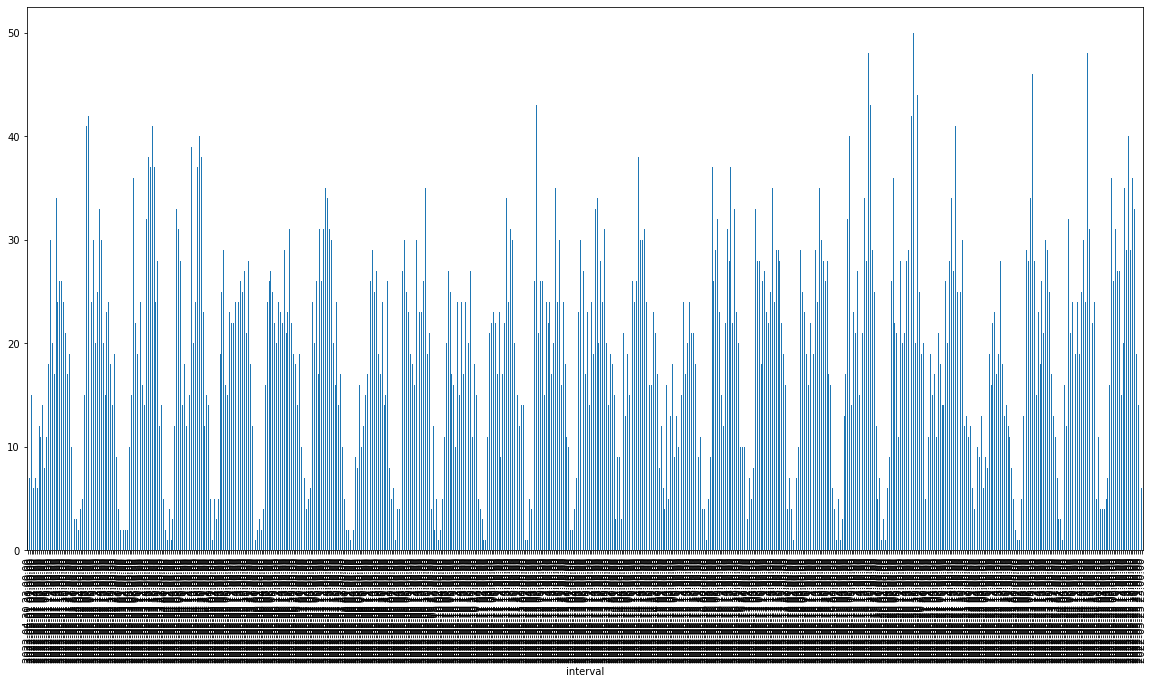

In [52]:
#barplot of incidents per interval
incidentsdf.groupby(["interval"]).count()["priority"].plot(kind="bar")
plt.show()

In [28]:
agentsdf = pd.read_csv('agents_may.csv', usecols=["dev_id", "time_stamp", "latitude", "longitude"])

#cast time_stamp to datetime
agentsdf["time_stamp"] = pd.to_datetime(agentsdf["time_stamp"])

#calculate intervals and create column
new = agentsdf.groupby(pd.Grouper(key="time_stamp", freq='1H')).apply(lambda x: x['time_stamp'])
agentsdf["interval"] = new.index.get_level_values(0)

#multiindex by interval, then id
agentsdf = agentsdf.set_index(["interval", "dev_id"])

#print head
agentsdf.head()

time_stamp  latitude  longitude
interval   dev_id                                                  
2022-05-01 868033050089715 2022-05-01 00:01:40  4.551646 -74.108515
           868033050102534 2022-05-01 00:01:42  4.650030 -74.147322
           868033050090085 2022-05-01 00:01:47  4.581688 -74.128348
           868033050103508 2022-05-01 00:01:52  4.551098 -74.147635
           868033050101650 2022-05-01 00:01:55  4.619840 -74.159668

In [13]:
incidents_locations = incidentsdf[["longitude","latitude"]].apply(lambda x: ','.join(x.values.astype(str)), axis=1)
incidents_locations.head()

interval    id   
2022-04-30  57518       -74.127685546875,4.705278873443604
            57519    -74.14337921142578,4.6005706787109375
2022-05-01  57520    -74.13712310791016,4.6477766036987305
            57521     -74.07530212402344,4.720405101776123
            57522     -74.16725158691406,4.614258289337158
dtype: object

In [14]:
agents_locations = agentsdf[["longitude","latitude"]].apply(lambda x: ','.join(x.values.astype(str)), axis=1)
agents_locations.head()

interval    dev_id         
2022-05-01  868033050089715     -74.108515,4.5516463
            868033050102534    -74.1473218,4.6500299
            868033050090085    -74.1283484,4.5816876
            868033050103508    -74.1476347,4.5510981
            868033050101650      -74.1596683,4.61984
dtype: object

In [15]:
incidents_sample = incidents_locations.sample(1000)
agents_sample = agents_locations.sample(1000)

In [59]:
incidents_sample = incidents_locations.xs("2022-05-01 00:00:00")
agents_sample = agents_locations.xs("2022-05-01 00:00:00").sample(100)

In [60]:
folium_map = folium.Map(
    location=[4.6534649, -74.0836453], zoom_start=12, tiles="CartoDB positron"
)

incidents_feature_group = folium.FeatureGroup(name="Incidents")
for i in range(len(incidents_sample)):
    marker = folium.CircleMarker(
        location=incidents_sample.iloc[i].split(",")[::-1],
        radius=1,
        color="red",
        fill=True,
        fill_opacity=0.3,
    )
    marker.add_to(incidents_feature_group)

agents_feature_group = folium.FeatureGroup(name="Agents")
for i in range(len(agents_sample)):
    marker = folium.CircleMarker(
        location=agents_sample.iloc[i].split(",")[::-1],
        radius=1,
        color="blue",
        fill=True,
        fill_opacity=0.3,
    )
    marker.add_to(agents_feature_group)

incidents_feature_group.add_to(folium_map)
agents_feature_group.add_to(folium_map)

folium.LayerControl().add_to(folium_map)
folium_map


In [61]:
agents_coordinates = ";".join(agents_sample)
incidents_coordinates = ";".join(incidents_sample)
coordinates = agents_coordinates + ";" + incidents_coordinates

agents_count = agents_sample.shape[0]
sources = ";".join(str(i) for i in range(agents_count))

incidents_count = incidents_sample.shape[0]
destinations = ";".join(
    str(i) for i in range(agents_count, agents_count + incidents_count)
)

#Ojo con correr esto sin estar corriendo el servicio.
durations = json.loads(
    requests.get(
        f"http://127.0.0.1:5000/table/v1/driving/{coordinates}?sources={sources}&destinations={destinations}"
    ).text
)["durations"]


In [62]:
#Finally, we can create a dataframe with the durations in seconds.}

df = pd.DataFrame(durations)
#df = df.apply(lambda x: x/60)

#df = df.set_index(agents_sample.index.get_level_values(1))
#df = df.set_axis(list(incidents_sample.index.get_level_values(1)), axis=1)

df


,0,1,2,3,4,5,6,7,8,9,...,381,382,383,384,385,386,387,388,389,390
0,1780.0,2203.2,1174.8,1206.3,1248.1,1156.2,2097.2,1963.0,1890.4,1286.1,...,2385.5,956.1,2464.3,1151.2,1065.8,1749.0,1969.2,2574.2,1547.5,743.9
1,1041.6,1473.2,689.4,350.4,234.6,642.1,1367.2,1233.0,1160.4,772.0,...,1655.5,398.7,1734.3,637.1,551.7,1019.0,1253.6,1715.6,703.6,645.0
2,1166.2,1122.2,1389.0,1075.7,946.4,1367.4,1102.7,1118.3,1145.4,1398.9,...,1317.0,950.8,1395.8,1362.4,1277.0,926.5,1110.2,1257.6,468.1,1483.4
3,1995.2,1342.2,2218.0,1893.6,1875.5,2185.3,1460.2,1693.6,1895.9,2227.9,...,1674.5,1879.9,1711.4,2180.3,2094.9,1283.6,1731.0,1490.3,1312.1,2309.1
4,1356.2,1692.0,1062.7,839.7,422.7,1044.1,1631.1,1477.6,1423.4,1174.0,...,1874.3,171.7,1953.1,1039.1,953.7,1282.9,1469.5,1885.3,722.1,662.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,987.5,1194.8,1210.3,901.1,770.3,1192.8,1095.8,939.6,966.7,1220.2,...,1377.1,774.7,1455.9,1187.8,1102.4,759.0,931.5,1388.1,289.4,1307.3
96,473.3,1286.5,427.3,740.3,1066.3,586.3,940.9,864.8,799.4,437.2,...,1374.2,1090.0,1453.0,553.1,562.8,832.3,642.6,1657.5,833.5,798.0
97,1058.7,1394.5,953.9,614.9,411.7,906.6,1333.6,1199.2,1125.9,1036.5,...,1576.8,416.1,1655.6,901.6,816.2,985.4,1177.3,1587.8,419.0,948.7
98,829.8,543.1,1238.2,1005.6,1323.2,1197.0,280.8,171.1,533.1,1248.1,...,714.1,1346.9,792.9,1192.0,1106.6,417.3,382.9,914.1,896.1,1331.2


In [ ]:
df.to_csv("durations.csv")

---

In [ ]:
incidents_locations

interval             id   
2022-04-30 23:00:00  57518       -74.127685546875,4.705278873443604
                     57519    -74.14337921142578,4.6005706787109375
2022-05-01 00:00:00  57520    -74.13712310791016,4.6477766036987305
                     57521     -74.07530212402344,4.720405101776123
                     57522     -74.16725158691406,4.614258289337158
                                              ...                  
2022-05-25 23:00:00  68383      -74.0933609008789,4.744298934936523
                     68384        -74.0780258178711,4.6522536277771
                     68385     -74.12010192871094,4.678952693939209
                     68386     -74.03235626220703,4.703181266784668
                     68387     -74.08690643310547,4.753690242767334
Length: 10870, dtype: object

In [ ]:
    marker = folium.CircleMarker(
        location=incidents_sample.iloc[i].split(",")[::-1],
        radius=1,
        color="red",
        fill=True,
        fill_opacity=0.3,
    )

In [ ]:
df = pd.read_csv(
    "incidents_may.csv",
    usecols=["id", "priority", "implicated", "incident_time", "latitude", "longitude"],
)

# drop duplicates
df = df.drop_duplicates(subset="id", keep="first")

# cast incident_time to datetime
df["incident_time"] = pd.to_datetime(df["incident_time"])

# fill nan to 0 and cast implicated to int
df["implicated"] = df["implicated"].fillna(0)
df["implicated"] = df["implicated"].astype(int)

# calculate intervals and create column
new = df.groupby(pd.Grouper(key="incident_time", freq="1D")).apply(
    lambda x: x["incident_time"]
)
df["interval"] = new.index.get_level_values(0)

# multiindex by interval, then id
df = df.set_index(["interval", "id"])

# print head
df.head()


priority  latitude  longitude  implicated  \
interval   id                                                 
2022-04-30 57518         2  4.705279 -74.127686           2   
           57519         1  4.600571 -74.143379           3   
2022-05-01 57520         1  4.647777 -74.137123           1   
           57521         1  4.720405 -74.075302           2   
           57522         1  4.614258 -74.167252           2   

                       incident_time  
interval   id                         
2022-04-30 57518 2022-04-30 23:59:00  
           57519 2022-04-30 23:54:00  
2022-05-01 57520 2022-05-01 00:08:00  
           57521 2022-05-01 00:10:00  
           57522 2022-05-01 00:11:00

In [ ]:
df.index.get_level_values(0).unique()

DatetimeIndex(['2022-04-30', '2022-05-01', '2022-05-02', '2022-05-03',
               '2022-05-04', '2022-05-05', '2022-05-06', '2022-05-07',
               '2022-05-08', '2022-05-09', '2022-05-10', '2022-05-11',
               '2022-05-12', '2022-05-13', '2022-05-14', '2022-05-15',
               '2022-05-16', '2022-05-17', '2022-05-18', '2022-05-19',
               '2022-05-20', '2022-05-21', '2022-05-22', '2022-05-23',
               '2022-05-24', '2022-05-25'],
              dtype='datetime64[ns]', name='interval', freq=None)

In [ ]:
df[(df.index.get_level_values(0) == '2022-04-30')]

priority  latitude  longitude  implicated  \
interval   id                                                 
2022-04-30 57518         2  4.705279 -74.127686           2   
           57519         1  4.600571 -74.143379           3   

                       incident_time  
interval   id                         
2022-04-30 57518 2022-04-30 23:59:00  
           57519 2022-04-30 23:54:00

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly as py

# min day in your dataset
day = 1998

# your color-scale
scl = [[0.0, '#ffffff'],[0.2, '#b4a8ce'],[0.4, '#8573a9'],
       [0.6, '#7159a3'],[0.8, '#5732a1'],[1.0, '#2c0579']] # purples

data_slider = []
for day in df.index.get_level_values(0).unique():
    df_segmented =  df[(df.index.get_level_values(0) == day)]

    for col in df_segmented.columns:
        df_segmented[col] = df_segmented[col].astype(str)

    data_each_yr = dict(
                        type='choropleth',
                        locations = df_segmented['state'],
                        z=df_segmented['sightings'].astype(float),
                        locationmode='USA-states',
                        colorscale = scl,
                        colorbar= {'title':'# Sightings'})

    data_slider.append(data_each_yr)

steps = []
for i in range(len(data_slider)):
    step = dict(method='restyle',
                args=['visible', [False] * len(data_slider)],
                label='Day {}'.format(i + 1998))
    step['args'][1][i] = True
    steps.append(step)

sliders = [dict(active=0, pad={"t": 1}, steps=steps)]

layout = dict(title ='UFO Sightings by State Since 1998', geo=dict(scope='usa',
                       projection={'type': 'albers usa'}),
              sliders=sliders)

fig = dict(data=data_slider, layout=layout)
periscope.plotly(fig)

KeyError: 'years'

In [ ]:
# Selecting the day to display
day = '2022-05-01'
tmp = df.xs(day)

incidents_sample.iloc[i].split(",")[::-1]

# Create the figure and feed it all the prepared columns
fig = go.Figure(
    go.Scattermapbox(
        lat=tmp['lat'],
        lon=tmp['lon'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=tmp['size'],
            color=tmp['color']
        )
    )
)

# Specify layout information
fig.update_layout(
    mapbox=dict(
        center=go.layout.mapbox.Center(lat=45, lon=-73),
        zoom=1
    )
)

# Display the figure
fig.show()